In [ ]:
pip install imblearn

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter1/framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
heart = pd.read_csv(file_content_stream)
heart = heart.dropna()
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Classification on Inbalanced Data

In [2]:
## frequency table of target 
heart['TenYearCHD'].value_counts() / heart.shape[0]

0    0.847648
1    0.152352
Name: TenYearCHD, dtype: float64

In [3]:
## Defining input and target variables
X = heart[['age',  'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']]
Y = heart['TenYearCHD']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a random forest model 
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       1.00      0.01      0.02       112

    accuracy                           0.85       732
   macro avg       0.92      0.50      0.47       732
weighted avg       0.87      0.85      0.78       732



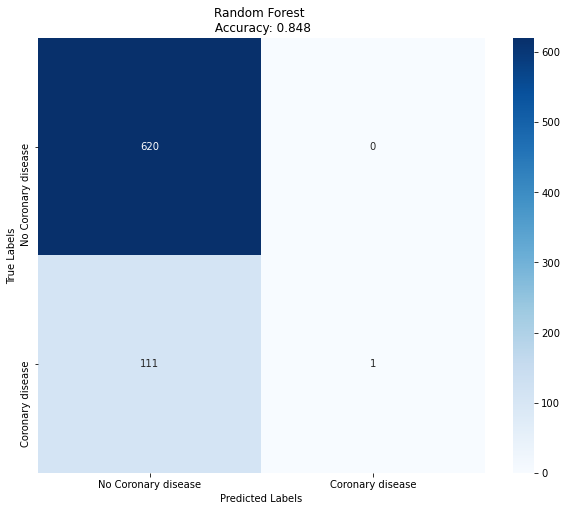

In [4]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot1.pdf')
plt.show()

## Dealing with Class-Imbalanced Data: Class Weights

In [31]:
## Building a random forest model (including weights)
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3, class_weight = 'balanced').fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       620
           1       0.25      0.64      0.36       112

    accuracy                           0.65       732
   macro avg       0.58      0.64      0.56       732
weighted avg       0.81      0.65      0.69       732



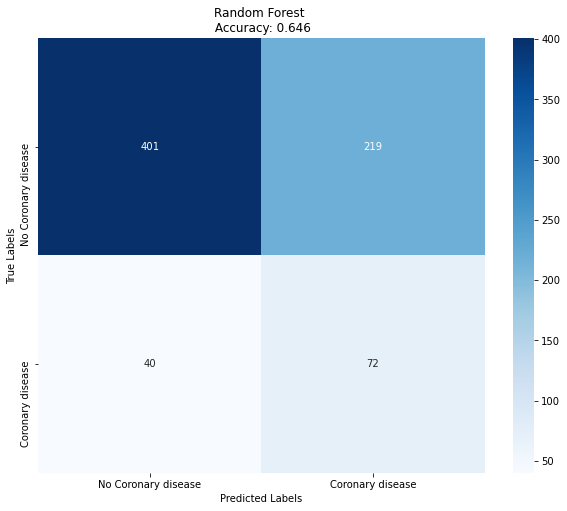

In [33]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot2.pdf')
plt.show()

## Under-Sampling

In [17]:
## Running under-sampling 
X_under, Y_under = RandomUnderSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_under = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_under, Y_under)

## Predicting on the test dataset
RF_pred_under = RF_under.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_under))

              precision    recall  f1-score   support

           0       0.91      0.58      0.71       620
           1       0.23      0.68      0.34       112

    accuracy                           0.60       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.81      0.60      0.65       732



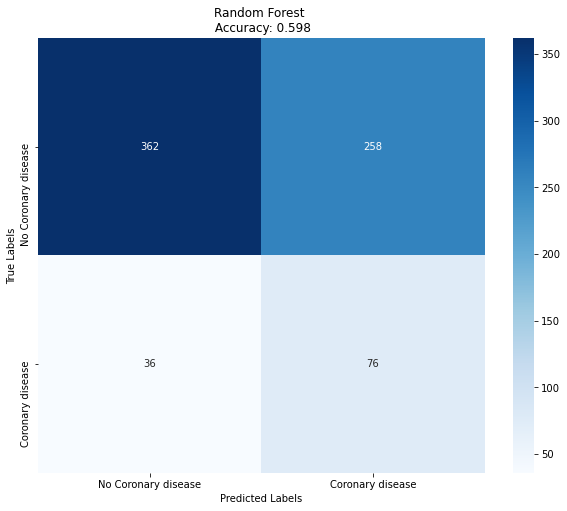

In [35]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_under)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_under)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot3.pdf')
plt.show()

## Over-Sampling

In [23]:
## Running over-sampling 
X_over, Y_over = RandomOverSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_over = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_over, Y_over)

## Predicting on the test dataset
RF_pred_over = RF_over.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_over))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       620
           1       0.23      0.65      0.34       112

    accuracy                           0.61       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.80      0.61      0.67       732



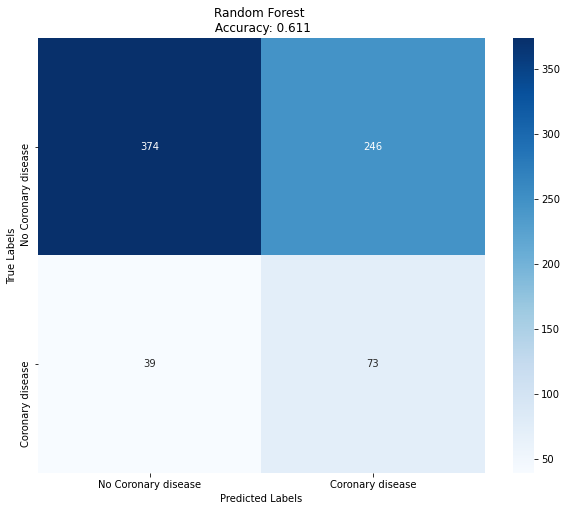

In [37]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_over)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_over)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot4.pdf')
plt.show()

## SMOTE

In [30]:
## Running SMOTE
X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_smote = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_smote, Y_smote)

## Predicting on the test dataset
RF_pred_smote = RF_over.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_smote))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       620
           1       0.23      0.65      0.34       112

    accuracy                           0.61       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.80      0.61      0.67       732



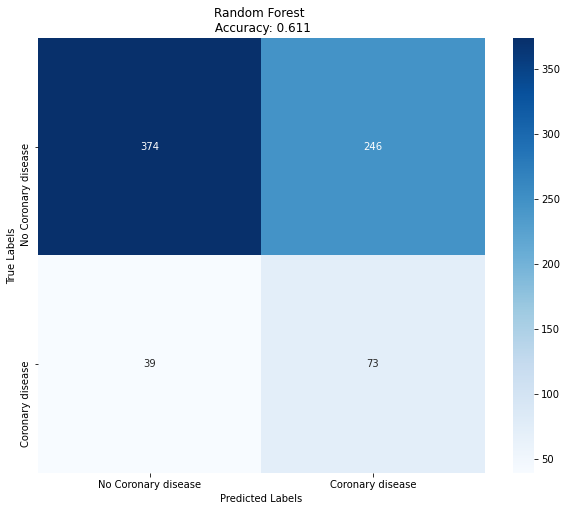

In [39]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_smote)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_smote)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot5.pdf')
plt.show()